In [9]:
# from sim_bfr_240611.config import RAW_DATA_DIR
RAW_DATA_DIR = 'Greg_simulation'
import scipp as sc
import plopp as pp
import scippneutron as scn
import scippnexus as snx
import numpy as np
from easyscience.Objects.new_variable import Parameter
from easyscience.Objects.ObjectClasses import BaseObj
from easyscience.fitting import Fitter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [10]:
filename=RAW_DATA_DIR +"/BIFROST_20240610T151842.h5"
dg = snx.File(filename)

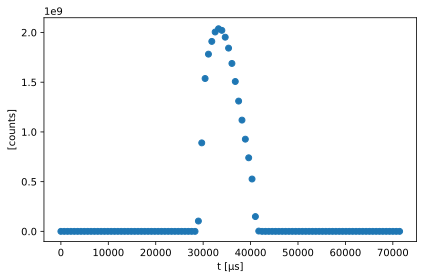

In [11]:
# example_data=dg['/entry/instrument/110_frame_3']['data']['time',1]
example_data=dg['/entry/instrument/090_frame_1']['data']['time',1]
# example_data=dg['/entry/instrument/007_frame_0']['data']['time',1]

example_data.coords['t']=sc.midpoints(example_data.coords['t']) # convert from bin edges to bin centers

# Plotting the data is very simple. You can pass more arguments to the plot function if you want.
example_data.plot()



In [12]:
# Define a fit function. In this simple example the fit parameters are global variables.
def Gaussian(x: np.ndarray) -> np.ndarray:
    """
    Mathematical model for a Gaussian function.
    
    :x: values to calculate the model over. 
    :A: amplitude of the Gaussian.
    :mu: mean (center) of the Gaussian.
    :sigma: standard deviation of the Gaussian.
    :BG: background.
    
    :return: model values.
    """
    return A.value * np.exp(-0.5 * ((x - mu.value) / sigma.value) ** 2)+BG.value


# The easyscience workflow is to create a function, then define the relevant Parameters. The Parameters are collected in a BaseObj, which is then passed to the Fitter along with the fit function.
# To fit the data, we pass x, y and weights to the fitter.

#Create easyscience Parameters with starting values and optional constraints
A=Parameter(name='A', value=2e9, fixed=False,min=0)
mu=Parameter(name='mu', value=30000, fixed=False)
# mu=Parameter(name='mu', value=9000, fixed=False)
sigma=Parameter(name='sigma', value=1500, fixed=False,min=0)
BG=Parameter(name='BG', value=0.1, fixed=False,min=0)

#Create easyscience BaseObj with the Gaussian model and the Parameters
Gaussian_Obj = BaseObj(name='Gaussian_Obj', A=A, mu=mu, sigma=sigma,BG=BG)
f = Fitter(Gaussian_Obj, Gaussian )
# You can do more things here, such as changing the fit method. Let's stick with the default for now.


In [13]:
# Extract x, y and errors to pass to the fitter.
x=example_data.coords['t'].values
y=example_data.values
yerr=np.sqrt(example_data.variances+1e7) # adding a constant to the variance to avoid problems at the tails

# Carry out the fitting,.
res=f.fit(x=x, y=y, weights=1/yerr)
# res=f.fit(x=x, y=y, weights=np.sqrt(y))
A,mu,sigma,BG



(<Parameter 'A': 2432216160.1011 ± 206036987.9111, bounds=[0.0:inf]>,
 <Parameter 'mu': 35361.9572 ± 134.2069, bounds=[-inf:inf]>,
 <Parameter 'sigma': 1647.8314 ± 48.2259, bounds=[0.0:inf]>,
 <Parameter 'BG': 5.1748 ± 20754.6410, bounds=[0.0:inf]>)

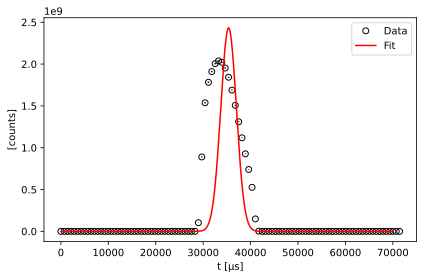

In [14]:


# Calculate the fit values for the x values of the data
xx=np.linspace(0,70000,5000) # Plot the fit on a smoother curve by using more points
fit_values=sc.array(values=Gaussian(xx),dims='t',unit='counts')

# Put the fit into a DataArray for plotting. We need to tell scipp what the units are.
Fit=sc.DataArray(data=fit_values,coords={'t': sc.array(values=xx,dims='t',unit='micro*s')})

data_and_fit=sc.DataGroup({'Data': example_data,
                          'Fit': Fit})

# We use plopp to plot the data and the fit
pp.plot(data_and_fit,
        linestyle=         {'Data': 'none',    'Fit': '-'},
        marker=            {'Data': 'o',       'Fit':'none'},
        markerfacecolor=   {'Data': 'none',    'Fit':'red'},
        color=             {'Data': 'black',   'Fit':'red'})


